In [25]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from my_metrices import MAE, MAPE, NRMSE, TOTAL_MAE, TOTAL_MAPE
from my_utils import std_scale, std_scale_back
from my_models import RNN_model, CNN_model

from tensorflow.keras.utils import plot_model


In [2]:
# loading data from files
df = pd.read_csv('pollution_us_2000_2016.csv')[
    ['State Code', 'County Code', 'Site Num', 'Address', 'State', 'County', 'City',
     'Date Local', 'O3 Mean', 'NO2 Mean', 'SO2 Mean', 'CO Mean']
].groupby(
    ['Site Num', 'Date Local', 'State Code', 'County Code', 'Address', 'State', 'County', 'City']
).agg(
    {
    'O3 Mean': 'mean',
    'NO2 Mean': 'mean',
    'SO2 Mean': 'mean', 
    'CO Mean': 'mean'
    }
).reset_index()

In [3]:
lst_site = df['Site Num'].unique()
lst_feature = ['O3 Mean', 'NO2 Mean', 'SO2 Mean', 'CO Mean']
list_input_size = range(90, 721, 90)
list_output_size = range(7, 30, 7)
list_stride = range(1, 8)

list_hyper = []
for site_num in [1,2,3]:
    for feature in ['O3 Mean', 'NO2 Mean', 'SO2 Mean', 'CO Mean']:
        for input_size in range(90, 721, 90):
            for output_size in range(7, 30, 7):
                for input_stride in range(1, 8):
                    list_hyper.append((site_num,feature,input_size,output_size,input_stride))

In [ ]:
num_epochs = 20
BATCH_SIZE = 32

# lst_site = df['Site Num'].unique()
# lst_feature = ['O3 Mean', 'NO2 Mean', 'SO2 Mean', 'CO Mean']
# list_input_size = range(90, 721, 90)
# list_output_size = range(7, 30, 7)
# list_stride = range(1, 8)

# input_size = 365
# output_size = 10
# input_stride = 1
# site_num = 1
# feature = 'NO2 Mean'

start_time = time.time()

if not os.path.exists('./weights/'):
    os.makedirs('./weights/')
for i, (site_num,feature,input_size,output_size,input_stride) in enumerate(list_hyper):
    # loading data
    site_df = df[df['Site Num'] == site_num]
    start_date, end_date = site_df.iloc[0]['Date Local'], site_df.iloc[-1]['Date Local']
    site_df = site_df[lst_feature]
    index = { name: index for index, name in enumerate(lst_feature)}[feature]
    data = site_df.values[:, index]
    scaled_data = std_scale(data, data)


    # create train testing
    lst_input = []
    lst_output = []
    last_start_index = scaled_data.shape[0] - ((input_size-1) * input_stride + 1 + output_size)
    for index in range(last_start_index):
        input_idxs = [ index + input_stride*i for i in range(input_size)]
        output_idxs = [ index + (input_size-1) * input_stride + 1 + i for i in range(output_size)]
        lst_input.append(scaled_data[input_idxs])
        lst_output.append(scaled_data[output_idxs])

    inp = np.array(lst_input)
    outp = np.array(lst_output)
    X_train, X_test, y_train, y_test = train_test_split(inp, outp, test_size=0.1, random_state=0)

    
    model = CNN_model(X_train.shape[1], y_train.shape[1])

    print('{}/{} - {:.2f} - {:.2f}'.format(
        i, len(list_hyper),
        time.time()-start_time,
        (time.time()-start_time)/(i + 1)*(len(list_hyper)-i-1)
    ), end='\r')
    history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=num_epochs,
        validation_data=(X_test, y_test),
        verbose=0,
        callbacks=[
            ModelCheckpoint(
                filepath='./weights/cnn_{}_{}_{}_{}_{}.hd5'.format(
                    site_num, feature, input_size, output_size, input_stride
                ), 
            verbose=0, save_best_only=True)
        ]
    )

In [4]:
l_result = []
for file in os.listdir('./weights/'):
   
    if file.endswith('.hd5'):
        model_type, site_num, feature, input_size, output_size, input_stride = file[:-4].split('_')
        site_num = eval(site_num)
        input_size = eval(input_size)
        output_size = eval(output_size)
        input_stride = eval(input_stride)


        site_df = df[df['Site Num'] == site_num]
        start_date, end_date = site_df.iloc[0]['Date Local'], site_df.iloc[-1]['Date Local']
        site_df = site_df[lst_feature]
        index = { name: index for index, name in enumerate(lst_feature)}[feature]
        data = site_df.values[:, index]
        scaled_data = std_scale(data, data)


        # create train testing
        lst_input = []
        lst_output = []
        last_start_index = scaled_data.shape[0] - ((input_size-1) * input_stride + 1 + output_size)
        for index in range(last_start_index):
            input_idxs = [ index + input_stride*i for i in range(input_size)]
            output_idxs = [ index + (input_size-1) * input_stride + 1 + i for i in range(output_size)]
            lst_input.append(scaled_data[input_idxs])
            lst_output.append(scaled_data[output_idxs])

        inp = np.array(lst_input)
        outp = np.array(lst_output)
        X_train, X_test, y_train, y_test = train_test_split(inp, outp, test_size=0.1, random_state=0)


        model = CNN_model(X_train.shape[1], y_train.shape[1])
        model.load_weights('./weights/cnn_{}_{}_{}_{}_{}.hd5'.format(
            site_num, feature, input_size, output_size, input_stride
        ))
        
        result = []
        pred_y = model.predict(X_test)
        for __func_ in [MAPE, NRMSE, TOTAL_MAPE]:
            result.append(__func_(y_test, pred_y))
            
        for __func_ in [MAE, TOTAL_MAE]:
            result.append(std_scale_back(data, np.array([__func_(y_test, pred_y)]))[0])
        print(file)
        print(result)
        l_result.append(result)

cnn_1_O3 Mean_270_14_6.hd5
[2.2830859437459865, 0.5318372061561614, 0.27639251060019837, 0.03456685390436876, 0.04426453491574014]
cnn_1_O3 Mean_540_7_5.hd5
[1.952913085538252, 0.5665961422466577, 0.5643593735367957, 0.03459010008143598, 0.040175412081063434]
cnn_1_O3 Mean_450_14_6.hd5
[2.6122926251310448, 0.5594417514563746, 1.0468203438104828, 0.03472960250035602, 0.043642791357002234]
cnn_1_O3 Mean_450_14_7.hd5
[2.9880614966894217, 0.5765851789634453, 1.5779445538740395, 0.0349926066853915, 0.046460122919903736]
cnn_1_O3 Mean_540_21_1.hd5
[2.1112252514349423, 0.42777100320217465, 0.14651072900148351, 0.03375260829073274, 0.04364351306035721]
cnn_1_O3 Mean_270_7_6.hd5
[2.8529676937309865, 0.5393639958729148, 0.5288221642438108, 0.03461092161121751, 0.04081562673072936]
cnn_1_O3 Mean_450_7_6.hd5
[2.027713467942678, 0.5802496536920828, 0.4170550599247196, 0.03477194103747353, 0.0425389963207892]
cnn_1_O3 Mean_90_28_2.hd5
[1.8896276208464347, 0.40328590602309444, 0.2391942188387612, 0.0

cnn_1_O3 Mean_630_14_7.hd5
[1.6529334194865668, 0.6509540920694259, 0.19465044705412593, 0.03408888135395275, 0.03930605102046572]
cnn_1_O3 Mean_180_28_4.hd5
[2.465551779464757, 0.4804893523110126, 0.3118833114591456, 0.03410631529931768, 0.0489979008019073]
cnn_1_O3 Mean_450_28_3.hd5
[2.3801218590299498, 0.5134270710821294, 0.24753757187597525, 0.03432687487217538, 0.04983030985646183]
cnn_1_O3 Mean_270_7_5.hd5
[2.0304125561114725, 0.5360140526702466, 0.4877503956178501, 0.034547179112752804, 0.040691100525843286]
cnn_1_O3 Mean_90_14_5.hd5
[2.3879982760440304, 0.49103449023019635, 2.08180521974307, 0.03426833561987157, 0.04492282518341485]
cnn_1_O3 Mean_450_7_4.hd5
[2.3149578198989254, 0.544963647367832, 0.5915197342766072, 0.034534858762290614, 0.04266666748886842]
cnn_1_O3 Mean_180_7_4.hd5
[2.601242804660614, 0.5277434086483156, 0.5378085368415797, 0.03443366275191476, 0.041628069287303934]
cnn_1_O3 Mean_360_7_7.hd5
[2.1429258577757517, 0.5840772902679594, 0.4967610969676412, 0.0348

cnn_1_O3 Mean_450_21_6.hd5
[2.5797059531448223, 0.5347284877720686, 0.29947942491843993, 0.034486672112843834, 0.047030019966914985]
cnn_1_O3 Mean_180_28_5.hd5
[2.2011441243604497, 0.47610320745532414, 0.3192717550902537, 0.03420975341915615, 0.04983335579624096]
cnn_1_O3 Mean_90_21_6.hd5
[2.6978419444433217, 0.4886681246911196, 0.34724778926452815, 0.034254744091791814, 0.04753421252898349]
cnn_1_O3 Mean_180_21_6.hd5
[2.3823637353875826, 0.49088228144499235, 0.5284548036383879, 0.034203245358900146, 0.046700139637148315]
cnn_1_O3 Mean_180_14_5.hd5
[2.864257855671539, 0.5014055927111472, 2.0062919732491333, 0.034410498926704704, 0.044599804054282405]
cnn_1_O3 Mean_180_7_3.hd5
[2.7778306992659743, 0.5028888907490676, 0.6825456774681468, 0.03432556178722636, 0.03920423596970306]
cnn_1_O3 Mean_180_7_1.hd5
[2.012374709354611, 0.40379829554514013, 0.7347102758902975, 0.033496942352400624, 0.03715348441649064]
cnn_1_O3 Mean_270_7_7.hd5
[3.428891959512648, 0.5656567840223327, 0.52422194915833

cnn_1_O3 Mean_270_28_6.hd5
[2.215526869112053, 0.5174856972612637, 1.1614523636021234, 0.03442966053997259, 0.05046864452953434]
cnn_1_O3 Mean_540_28_7.hd5
[1.7750122370338843, 0.5794123239591296, 0.6304936493811156, 0.03474822397754242, 0.04938434646587769]
cnn_1_O3 Mean_270_28_3.hd5
[2.2355990187787076, 0.480820195482729, 0.21798577859541643, 0.03415841758823243, 0.050580094188218745]
cnn_1_O3 Mean_90_21_1.hd5
[1.2302063818798543, 0.2822574278689644, 0.2728777596386285, 0.03249958094493008, 0.04175744406926406]
cnn_1_O3 Mean_630_21_5.hd5
[2.960199312578696, 0.5673551722359237, 0.228259923282056, 0.03488999650431036, 0.0493566965463232]
cnn_1_O3 Mean_90_28_1.hd5
[1.5141338141754883, 0.27704536104091804, 0.2896448663441751, 0.032433261943894585, 0.04497207387107411]
cnn_1_O3 Mean_540_21_7.hd5
[2.702200656393163, 0.5622519819669248, 1.5287405234716416, 0.03473346472159472, 0.04826525394550738]
cnn_1_O3 Mean_360_14_6.hd5
[2.4984937795058, 0.5398978415975436, 0.2501075194051618, 0.0345925

In [13]:
l_result = np.array(l_result)
for i in range(l_result.shape[1]):
    idx = np.argmin(np.array(l_result)[:, i])
    mean = np.array(l_result)[:, i].mean()
    std = np.array(l_result)[:, i].std()
    mini = np.array(l_result)[idx, i]
    print(idx, mean, std, mini, os.listdir('./weights/')[idx])


193 2.322045328978085 0.37838954747648573 1.2302063818798543 cnn_1_O3 Mean_270_28_3.hd5
195 0.5011942376259056 0.06630251321032302 0.27704536104091804 cnn_1_O3 Mean_630_21_5.hd5
60 0.4944426531190517 0.35991242062711165 0.033183742644411096 cnn_1_O3 Mean_90_7_4.hd5
195 0.034250735126502195 0.00048282155095488727 0.032433261943894585 cnn_1_O3 Mean_630_21_5.hd5
60 0.044476890317360816 0.00432689593119256 0.034589369944340705 cnn_1_O3 Mean_90_7_4.hd5


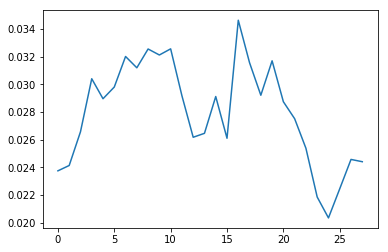

In [17]:
# MAPE, NRMSE, TOTAL_MAPE, MAE, TOTAL_MAE
file = './weights/cnn_1_O3 Mean_270_28_3.hd5'

model_type, site_num, feature, input_size, output_size, input_stride = file[:-4].split('_')
site_num = eval(site_num)
input_size = eval(input_size)
output_size = eval(output_size)
input_stride = eval(input_stride)


site_df = df[df['Site Num'] == site_num]
start_date, end_date = site_df.iloc[0]['Date Local'], site_df.iloc[-1]['Date Local']
site_df = site_df[lst_feature]
index = { name: index for index, name in enumerate(lst_feature)}[feature]
data = site_df.values[:, index]
scaled_data = std_scale(data, data)


# create train testing
lst_input = []
lst_output = []
last_start_index = scaled_data.shape[0] - ((input_size-1) * input_stride + 1 + output_size)
for index in range(last_start_index):
    input_idxs = [ index + input_stride*i for i in range(input_size)]
    output_idxs = [ index + (input_size-1) * input_stride + 1 + i for i in range(output_size)]
    lst_input.append(scaled_data[input_idxs])
    lst_output.append(scaled_data[output_idxs])

inp = np.array(lst_input)
outp = np.array(lst_output)
X_train, X_test, y_train, y_test = train_test_split(inp, outp, test_size=0.1, random_state=0)


model = CNN_model(X_train.shape[1], y_train.shape[1])
model.load_weights('./weights/cnn_{}_{}_{}_{}_{}.hd5'.format(
    site_num, feature, input_size, output_size, input_stride
))
y_pred = model.predict(X_test)


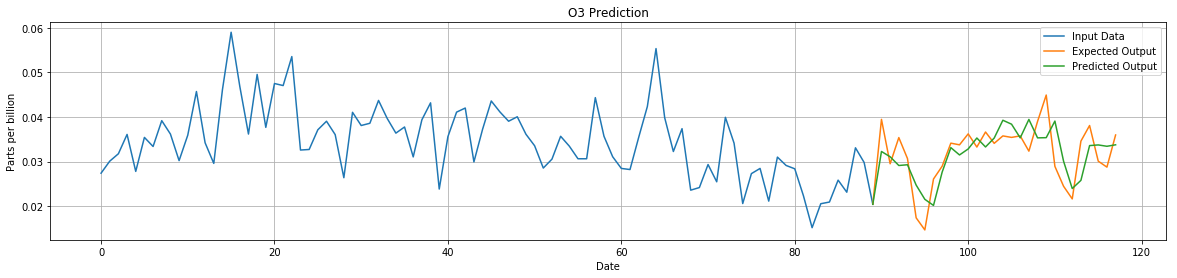

In [69]:
x = std_scale_back(data, X_test)
y = std_scale_back(data, y_test)
pred_y = std_scale_back(data, y_pred)
feature, input_size, output_size, input_stride

i = 1

x_ = x[: , :x.shape[1]//3]

plt.figure(figsize=(20,4))
plt.plot(x_[i], label="Input Data")
plt.plot([ x_.shape[1] + i -1 for i in range(output_size + 1)], np.insert(y[i], 0, x_[i][-1]), label="Expected Output")
plt.plot([ x_.shape[1] + i -1 for i in range(output_size + 1)], np.insert(pred_y[i], 0, x_[i][-1]), label="Predicted Output")

plt.legend()
plt.grid()
plt.title('O3 Prediction')
plt.xlabel('Date')
plt.ylabel('Parts per billion')
plt.show()
# for i in range(y_pred.shape[0]):
#     plt.plot(std_scale_back(data, y_pred)[i])
#     plt.plot(std_scale_back(data, y_test)[i])
#     

In [ ]:
model = CNN_model(X_train.shape[1], y_train.shape[1])
plot_model(model, to_file='model.png', show_shapes=True)

In [75]:
def baseline_pred(train, test):
    return np.ones(test.shape) * train.mean()

In [79]:
baseline_y = baseline_pred(X_train, y_test)
for __func_ in [MAPE, NRMSE, TOTAL_MAPE]:
    print(__func_(y_test, baseline_y))

for __func_ in [MAE, TOTAL_MAE]:
    print(std_scale_back(data, np.array([__func_(y_test, baseline_y)]))[0])

0.9993117846543467
0.998436243542846
0.9996542352641932
0.03870178022552849
0.22235851804423998


In [82]:
for item in l_result[193]:
    print(item)

1.2302063818798543
0.2822574278689644
0.2728777596386285
0.03249958094493008
0.04175744406926406


In [105]:
file = './weights/cnn_1_O3 Mean_270_28_3.hd5'

model_type, site_num, feature, input_size, output_size, input_stride = file[:-4].split('_')
site_num = eval(site_num)
input_size = eval(input_size)
output_size = eval(output_size)
input_stride = eval(input_stride)


site_df = df[df['Site Num'] == site_num]
start_date, end_date = site_df.iloc[0]['Date Local'], site_df.iloc[-1]['Date Local']
site_df = site_df[lst_feature]
index = { name: index for index, name in enumerate(lst_feature)}[feature]
data = site_df.values[:, index]
scaled_data = std_scale(data, data)


# create train testing
lst_input = []
lst_output = []
last_start_index = scaled_data.shape[0] - ((input_size-1) * input_stride + 1 + output_size)
for index in range(last_start_index):
    input_idxs = [ index + input_stride*i for i in range(input_size)]
    output_idxs = [ index + (input_size-1) * input_stride + 1 + i for i in range(output_size)]
    lst_input.append(scaled_data[input_idxs])
    lst_output.append(scaled_data[output_idxs])

inp = np.array(lst_input)
outp = np.array(lst_output)
X_train, X_test, y_train, y_test = train_test_split(inp, outp, test_size=0.1, random_state=0)


model = CNN_model(X_train.shape[1], y_train.shape[1])
model.load_weights('./weights/cnn_{}_{}_{}_{}_{}.hd5'.format(
    site_num, feature, input_size, output_size, input_stride
))
# y_pred = model.predict(X_test)


([<matplotlib.lines.Line2D at 0x7f2ff493e630>],)

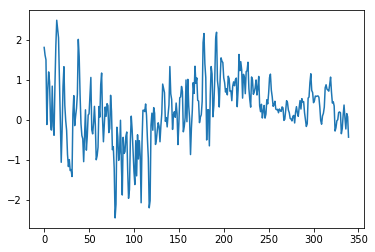

In [132]:
pipeline = np.copy(scaled_data)

def get_input(pipeline, input_size, input_stride):
    count = 0 
    result = []
    for idx in range(pipeline.shape[0] - 1, -1, -3):
        if count < input_size:
            result = [pipeline[idx]] + result
            count += 1
        else:
            break
        
    return np.array(result)

def pipeline_predict(pipeline, input_size, input_stride, number_rounds = 5):
    for i in range(number_rounds):
        inp = get_input(pipeline, input_size, input_stride)
        y_pred = model.predict(np.array([inp]))[0]
        
        
        pipeline = np.concatenate((pipeline, y_pred))
        
    return pipeline

pipeline = pipeline_predict(pipeline, input_size, input_stride)



plt.plot(pipeline[scaled_data.shape[0] - 200 : ]), 

MovieWriter Pillow unavailable. Trying to use pillow instead.


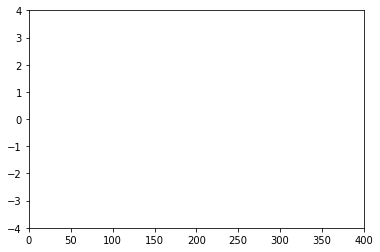

In [133]:

from matplotlib import pyplot as plt
from celluloid import Camera
import numpy as np


# create figure object
fig = plt.figure()
# load axis box
ax = plt.axes()
# set axis limit
ax.set_ylim(-4, 4)
ax.set_xlim(0, 400)

camera = Camera(fig)
for i in range(50):
    ax.plot()
    # ax.scatter(i, np.random.random())
    # plt.pause(0.1)
    camera.snap()

animation = camera.animate()
animation.save('animation.gif', writer='Pillow', fps=2)

In [209]:
pipeline = std_scale_back(data,pipeline)

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


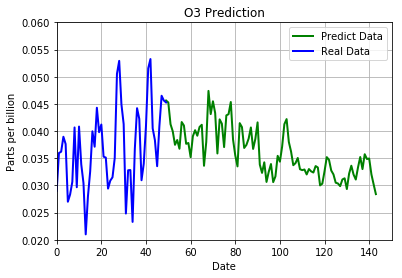

In [236]:
init_window = 50



import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 150), ylim=(0.02, 0.06))
plt.grid()
plt.title('O3 Prediction')
plt.xlabel('Date')
plt.ylabel('Parts per billion')
line, = ax.plot([], [], lw=2, color='g', label='Predict Data')
line2, = ax.plot([], [], lw=2, color='b', label='Real Data')

# initialization function: plot the background of each frame
def init():
    line2.set_data([i for i in range(init_window)], pipeline[scaled_data.shape[0] - init_window: scaled_data.shape[0]])
    return line2,

# animation function.  This is called sequentially
def animate(i):
    print()
    line.set_data(
        [ init_window + idx -1 for idx in range(i * 5)], 
        pipeline[scaled_data.shape[0] -2 : scaled_data.shape[0] + i * 5 -2]
    )
    return line,
plt.legend()
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=30, blit=True, repeat=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.gif', fps=15, extra_args=['-vcodec', 'libx264'])

plt.show()

In [225]:
df[df['Site Num'] == 1]['Date Local'].values

array(['2000-01-01', '2000-01-02', '2000-01-03', ..., '2016-03-29',
       '2016-03-30', '2016-03-31'], dtype=object)

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


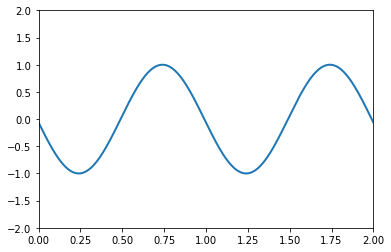

In [177]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([1,2], [1,2])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=20, blit=True)

anim.save('basic_animation.gif', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

(array([ 1.        , -0.31899694, -1.78981297, ...,  1.54723138,
         1.46420144,  1.42985077]),
 array([ 1.        , -0.31899694, -1.78981297, ...,  1.54723138,
         1.46420144,  1.42985077]))

In [88]:
scaled_data.shape, input_size, output_size, input_stride, 

((4477,), 270, 28, 3)

In [98]:
pipeline[0] = 1
scaled_data

array([ 1.        , -0.31899694, -1.78981297, ...,  1.54723138,
        1.46420144,  1.42985077])

In [ ]:
# model.load_weights('cnn_{}_{}_{}_{}_{}.hd5'.format(
#     site_num, feature, input_size, output_size, input_stride
# ))

In [ ]:
# pd.Series(scaled_data, index=pd.date_range(start_date, periods=scaled_data.shape[0])).plot();

In [ ]:
# plt.plot(history.history['val_mae'], label='val')
# plt.plot(history.history['mae'], label='train')
# plt.legend()
# plt.show()

In [ ]:
# num_epochs = 3

# model = RNN_model(X_train.shape[1], y_train.shape[1])
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=BATCH_SIZE,
#     epochs=num_epochs,
#     validation_data=(X_test, y_test),
#     # callbacks=[ModelCheckpoint(filepath=weight_path,verbose=0, save_best_only=True)]
# )


In [ ]:
# pred_y = model.predict(X_test)

# for i in range(X_test.shape[0]):
#     plt.plot(y_test[i])
#     plt.plot(pred_y[i])
#     plt.show()

# MAPE(y_test, pred_y)




input_length, output_length = X_train.shape[1], y_train.shape[1]

def MLP_model():
    # create model
    model = Sequential()
    model.add(Dense(500, input_dim=input_length, kernel_initializer='normal', activation='relu'))
    model.add(Dense(output_length, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    # model.summary()
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=MLP_model, epochs=10, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, inp, outp, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))
